## **Seq2Seq Model**

## The Seq2Seq model is a model consisting of two RNNs called the encoder and decoder. The decoder reads and input sequence and outputs a single vector, and the decoder reads the vector to produce an output sequence.

 ## An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

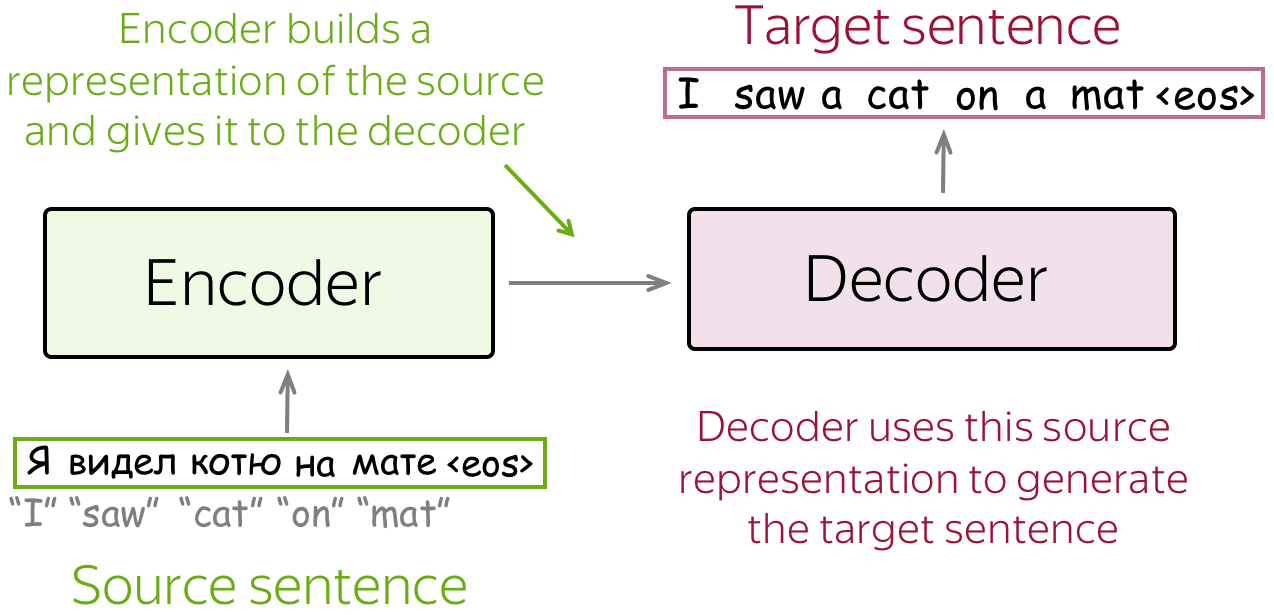

## The high-level pipeline for seq2seq translation is

 
*   
### Feed source and previously generated target words into a network
*  
### Get vector representations of context (both source and previous target) from the network's decoder

*  
### From this vector representation, predict a probability distribution for the next token




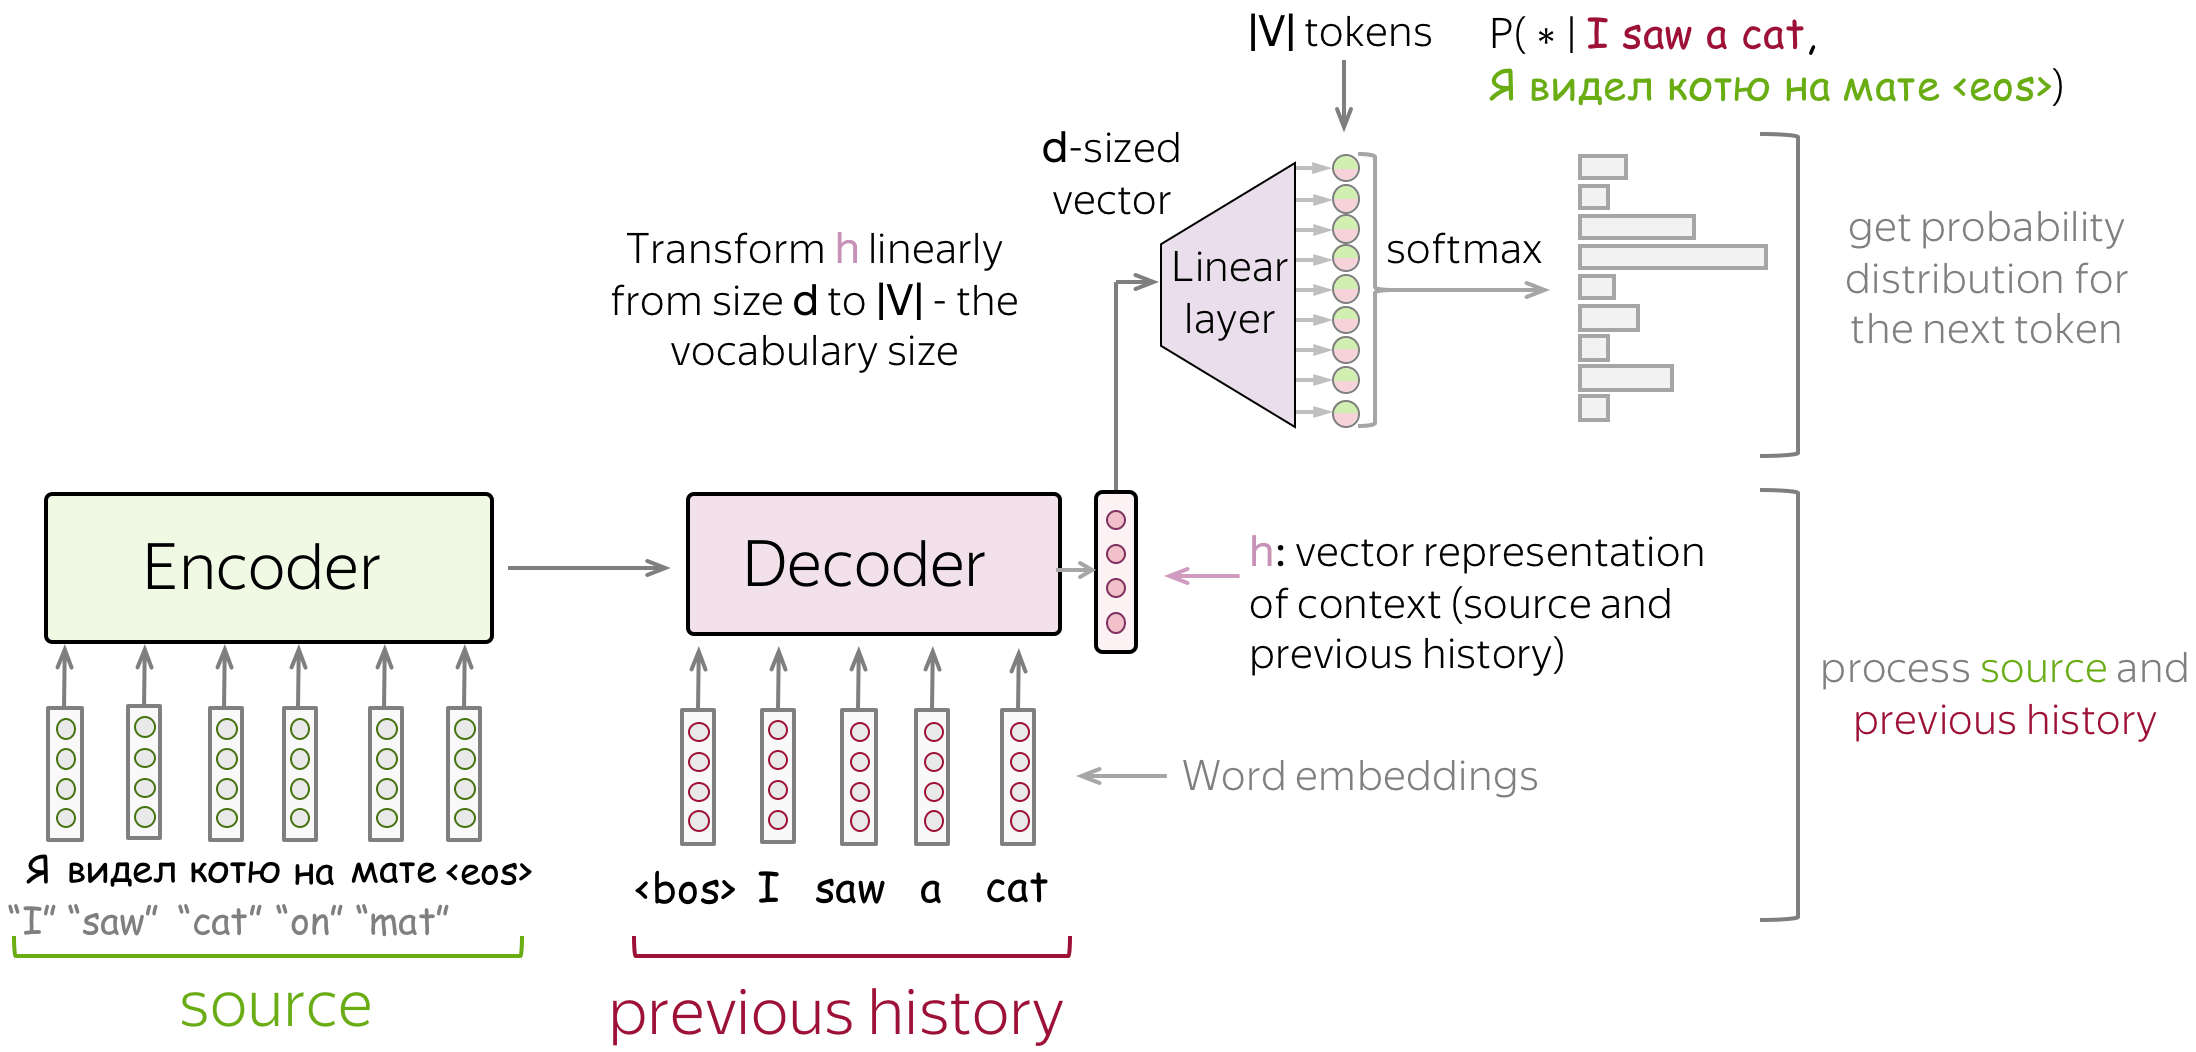

In [ ]:
from IPython.display import Image
Image(url="https://pytorch.org/tutorials/_images/seq2seq.png")

## The Simplest Model: Two RNN(LSTMs) for Encoder and Decoder
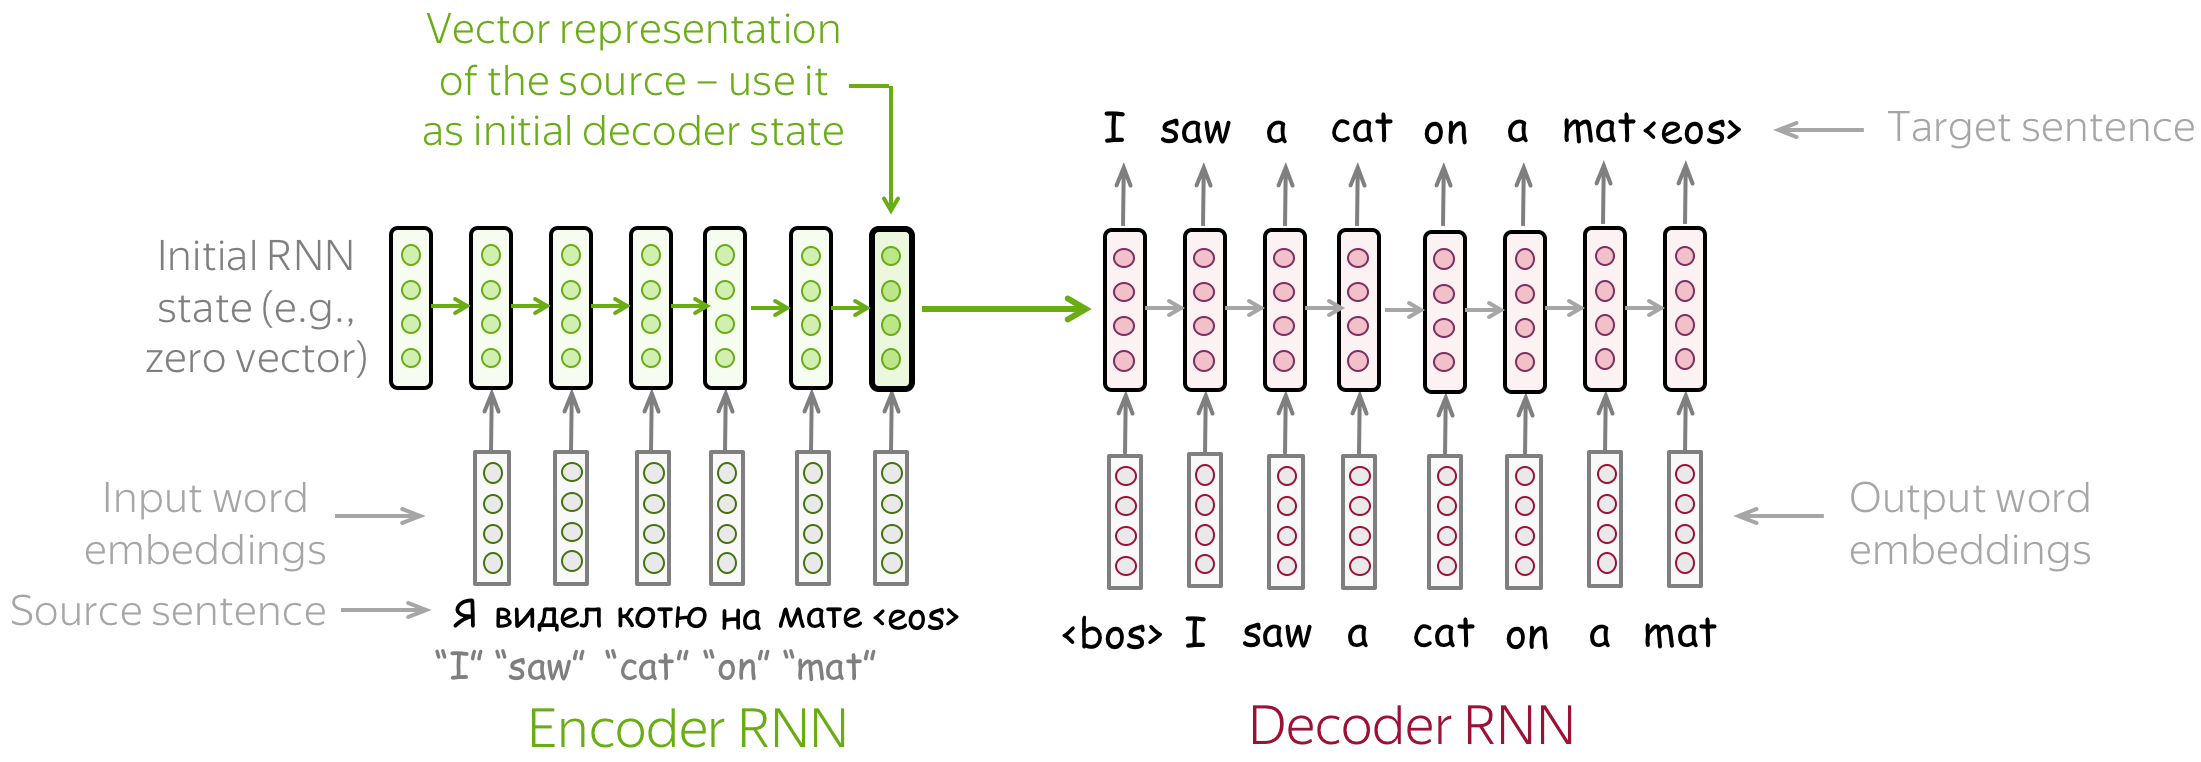

### Encoder RNN reads the source sentence, and the final state is used as the initial state of the decoder RNN. The hope is that the final encoder state "encodes" all information about the source, and the decoder can generate the target sentence based on this vector.

### Each word in a language is represented as a one hot vector, or giant vector of zeros except for a single one (at the index of the word).

In [ ]:
Image(url="https://pytorch.org/tutorials/_images/word-encoding.png")

## Training the Model

###seq2seq models are trained to predict probability distributions of the next token given previous context (source and previous target tokens). Intuitively, at each step we maximize the probability a model assigns to the correct token.

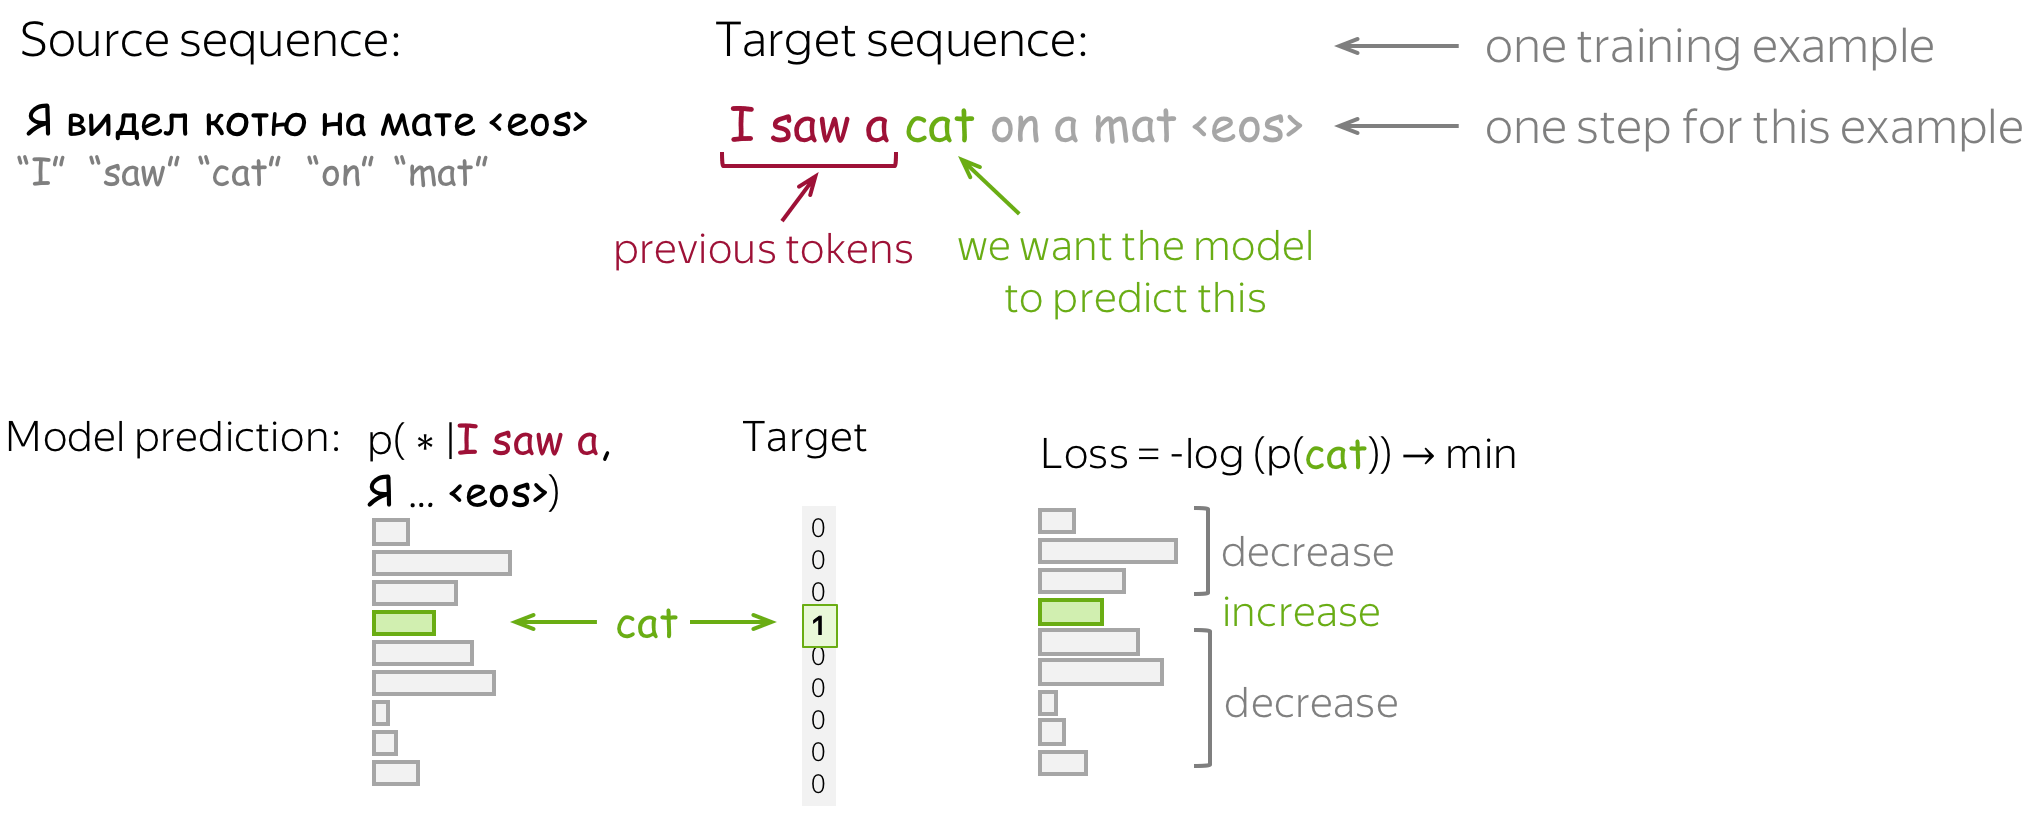

In [ ]:
!pip install -U torchtext==0.10.1

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
import numpy as np
import spacy
import random

In [ ]:
from torchtext.data.metrics import bleu_score
import sys


def translate_sentence(model, sentence, german, english, device, max_length=50):
    # Load german tokenizer
    spacy_ger = spacy.load("de_core_news_sm")

    # Create tokens using spacy and everything in lower case (which is what our vocab is)
    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_ger(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, german.init_token)
    tokens.append(german.eos_token)

    # Go through each german token and convert to an index
    text_to_indices = [german.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    outputs = [english.vocab.stoi["<sos>"]]
    
    for i in range(max_length):
        trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)

        with torch.no_grad():
            output = model(sentence_tensor, trg_tensor)

        best_guess = output.argmax(2)[-1, :].item()
        outputs.append(best_guess)

        if best_guess == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]
    # remove start token
    return translated_sentence[1:]


def bleu(data, model, german, english, device):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["src"]
        trg = vars(example)["trg"]

        prediction = translate_sentence(model, src, german, english, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
!python -m spacy download en_core_web_sm

2022-11-10 05:48:07.832335: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 7.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!python -m spacy download de_core_news_sm

2022-11-10 05:48:19.236932: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 7.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [ ]:
spacy_ger = spacy.load("de_core_news_sm") # load the German Tokenizer
spacy_eng = spacy.load("en_core_web_sm")  # load the English Tokenizer

In [ ]:
def tokenize_ger(text):
    return [tok.text for tok in spacy_ger.tokenizer(text)]


def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]


german = Field(tokenize=tokenize_ger, lower=True, init_token="<sos>", eos_token="<eos>")

english = Field(
    tokenize=tokenize_eng, lower=True, init_token="<sos>", eos_token="<eos>"
)

train_data, valid_data, test_data = Multi30k.splits(
    exts=(".de", ".en"), fields=(german, english)
)

german.build_vocab(train_data, max_size=10000, min_freq=2)
english.build_vocab(train_data, max_size=10000, min_freq=2)


class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)

    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        return hidden, cell


class Decoder(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(0)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs)

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(0)

        return predictions, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = len(english.vocab)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

        hidden, cell = self.encoder(source)

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[0]

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            output, hidden, cell = self.decoder(x, hidden, cell)

            # Store next output prediction
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs


### We're ready to define everything we need for training our Seq2Seq model ###

# Training hyperparameters
num_epochs = 2
learning_rate = 0.001
batch_size = 64

# Model hyperparameters
load_model = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size_encoder = len(german.vocab)
input_size_decoder = len(english.vocab)
output_size = len(english.vocab)
encoder_embedding_size = 100
decoder_embedding_size = 100
hidden_size = 256  # Needs to be the same for both RNN's
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device,
)

encoder_net = Encoder(
    input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = english.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)


sentence = "ein boot mit mehreren männern darauf wird von einem großen pferdegespann ans ufer gezogen."

for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")

    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    save_checkpoint(checkpoint)

    model.eval()

    translated_sentence = translate_sentence(
        model, sentence, german, english, device, max_length=50
    )

    print(f"Translated example sentence: \n {translated_sentence}")

    model.train()

    for batch_idx, batch in enumerate(train_iterator):
        # Get input and targets and get to cuda
        inp_data = batch.src.to(device)
        target = batch.trg.to(device)

        # Forward prop
        output = model(inp_data, target)

        # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have output_words * batch_size that we want to send in into
        # our cost function, so we need to do some reshapin. While we're at it
        # Let's also remove the start token while we're at it
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)

        # Back prop
        loss.backward()

        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()


score = bleu(test_data[1:100], model, german, english, device)
print(f"Bleu score {score*100:.2f}")

[Epoch 0 / 2]
=> Saving checkpoint
Translated example sentence: 
 ['<unk>', 'seats', 'op', 'task', 'wheeled', 'leaped', 'fake', 'pajamas', 'pajamas', 'leaped', 'op', 'op', 'loaded', 'leaped', 'leaped', 'pajamas', 'op', 'south', 'op', 'growing', 'leaped', 'loaded', 'screens', 'op', 'op', 'op', 'loaded', 'wheeled', 'loaded', 'pajamas', 'bathing', 'tower', 'op', 'loaded', 'wheeled', 'leaped', 'leaped', 'skyscraper', 'op', 'south', 'leaped', 'mold', 'leaped', 'op', 'op', 'leaped', 'leaped', 'leaped', 'op', 'screens']
[Epoch 1 / 2]
=> Saving checkpoint
Translated example sentence: 
 ['<unk>', 'a', 'young', 'man', 'man', 'a', 'on', 'a', 'a', 'a', 'a', 'a', 'a', 'a', '.', '.', '.', '<eos>']
Bleu score 0.00
